# The Comparison between KNN and Linear Regression on Predicting the Danceability of a Song on Spotify
Group 79: Steve (Zefan) Liu, Zeen Lin, Erin Lau, Eric Shuai

<em>Word Count: []</em>

In [2]:
# !!! TABLE OF CONTENTS
# !!! FIGURE (LEAGUE OF) LEGEND

<h2 style="color:#008a05">Introduction</h2>

After three long years of pandemic-styled living, the desire to return to the party-scene has cultivated a spark of excitement in communities worldwide[¹](https://www.npr.org/2021/04/17/987865318/life-in-the-roaring-2020s-young-people-prepare-to-party-reclaim-lost-pandemic-ye). To prepare for this upcoming age of buzz and festivities, it is essential for venues, DJ’s, and rising artists to consider the features of their music that increase the likelihood of dancing and fun. However, there are many predictors that can play a role in deciding how danceable a song is. Thus, through this project, our group aims to predict the danceability of an unknown song with two models and the accuracy of the two models will be compared based on their performances on test set. Meanwhile, the sets of predictory variables for the two models are different: the set for KNN regression based off predictors that we believe, having all learnt music theory, would play a role towards danceability, and the set for linear regression based off a systematic process of greedy selection (all subsets). We hope to compare the RMSE values of the two models to determine which of the models have better predictive performance.

**Question:** With different sets of predictors, which of the KNN regression and the linear regression will have a better predictive performance on the danceability, and why it is the case?

For this analysis, we will be using the **[Spotify Audio Features dataset](https://www.kaggle.com/datasets/tomigelo/spotify-audio-features)** (<https://www.kaggle.com/datasets/tomigelo/spotify-audio-features>) captured from April 2019 by the user *tomigelo*. This dataset was scraped via Spotify API and Python and consists of variables of audio features (e.g. acousticness, song length, key, etc.) provided by Spotify[²]() pertaining to a given song.

*¹ <https://www.npr.org/2021/04/17/987865318/life-in-the-roaring-2020s-young-people-prepare-to-party-reclaim-lost-pandemic-ye>
<br>² <https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features>*

<h2 style="color:#008a05">Method</h2>

For our analysis, we compared two models of danceability: one based off of a K-Nearest Neighbours Regression model using predictors that we believe are related to the danceability of a song, and another based off of a Linear Regression model that utilizes greedy selection to choose the set of predictors which has the lowest BIC value.

### K-NN Regression Model, the <span style="color:#e61a17">"Intuitive Model"</span>

##### <u><div style="text-align: center">Table 1.1: Predictor Descriptions</div></u>
| Predicted Variable                 | Name in Dataset | Type of data                |
|------------------------------------|-----------------|-----------------------------|
| **Danceability**                   | `danceability`  | (dbl, 0.0-1.0, no units)    |

| Predictor                          | Name in Dataset | Type of data                |
|------------------------------------|-----------------|-----------------------------|
| **Energy**                         | `energy`        | (dbl, 0.0-1.0, no units)    |
| **Tempo**                          | `tempo`         | (dbl, >= 0, BPM)            |
| **Valence** (musical positiveness) | `valence`       | (dbl, 0.0-1.0, no units)    |

For our first, <span style="color:#e61a17">"intuitive"</span> model, we performed rectangular k-nearest neighbours regression analysis based on three selectors: the energy, valence, and tempo of a song as predictor variables. Energy and tempo are crucial as they form the rhythmic backbones of a song’s danceability (which per [Spotify's definition](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features:~:text=Danceability%20describes%20how%20suitable%20a%20track%20is%20for%20dancing%20based%20on%20a%20combination%20of%20musical%20elements%20including%20tempo%2C%20rhythm%20stability%2C%20beat%20strength%2C%20and%20overall%20regularity.) is based on "elements including tempo, rhythm stability, beat strength, and overall regularity"), and the valence was selected as a song expressing higher positiveness could influence the listener to dance along.

### Linear Regression Model + Greedy Selection(all subsets), the <span style="color:#00bfff">"Systematic Model"</span>
##### <u><div style="text-align: center">Table 1.2: Predicted Variable Description</div></u>
| Predicted Variable                 | Name in Dataset | Type of data                |
|------------------------------------|-----------------|-----------------------------|
| **Danceability**                   | `danceability`  | (dbl, 0.0-1.0, no units)    |

Our second, <span style="color:#00bfff">"systematic"</span> model first has predictors selected from the training data set using the **greedy selection(all subsets)** technique, which iterates through all possible subsets of predictors until an optimal group of predictors have been selected.

After initial cleanup was completed (trimming `N/A` values, selecting, etc.), we first sampled the data proportionally due to a large dataset size, before splitting it into training/testing data. We then built our <span style="color:#e61a17">Intuitive Model</span>, utilising cross-validation to determine an optimal number of neighbours, $k$, which we used to retrain our model. Next, we built our <span style="color:#00bfff">Systematic Model</span> by performing the greedy selection algorithm and using the resulting predictors. Finally, we compared the performance of our two models using our testing set through the RMSE values and plots to see how well our <span style="color:#e61a17">Intuitive Model</span> compared to a systematically-designed model.

<h2 style="color:#008a05">Setting up our data</h2>

### Importing Libraries and Loading Data

Begin by setting up all the primary required libraries: `repr`, `tidyverse`, and `tidymodels`. We also load `GGally` so that we can use `ggpairs()` for data exploration, `gridExtra` to arrange plots, and will also need to install the `leaps` library to perform forward selection.

In [3]:
# ========== Setting up prerequisites libraries ==========
library(repr)
library(tidyverse)
library(tidymodels)
library(GGally)
library(gridExtra)

# Install the leaps package and load it
install.packages("leaps")
library(leaps)

options(repr.matrix.max.rows = 8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Let's load our data, which was downloaded from [Kaggle](https://www.kaggle.com/datasets/tomigelo/spotify-audio-features) and now hosted on our [project GitHub repository](https://github.com/eshuaiii/dsci-100-2022w1-group-79).

In [4]:
# ========== Load the data from the web into R ==========
dataset_url <- "https://github.com/eshuaiii/dsci-100-2022w1-group-79/raw/main/data/SpotifyAudioFeaturesApril2019.csv"

# read the dataset from URL
spotify_big <- read_csv(url(dataset_url))

# read the first 5 rows
head(spotify_big, 5)

Rows: 130663 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): artist_name, track_id, track_name
dbl (14): acousticness, danceability, duration_ms, energy, instrumentalness,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",5.82e-03,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),2.44e-02,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,2.50e-02,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,2.94e-02,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,3.52e-05,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0


### Sampling and Creating Tidy Data

Before we begin sampling our data, we must first address one key concern with our data.
The `tempo` value currently consists of all numbers from 0 (inclusive) onwards. This means that some songs in our dataset would have a tempo of 0, which made us question whether or not a real piece of music could have zero tempo. Through some exploratory analysis, we discovered that the observations that possessed zero tempo were recordings of white noise or podcast-like tracks, or tracks that Spotify was unable to identify, rather than actual music. As these recordings did not align with the goal of our project (that being to support DJ’s and music artists involved in the party scene), we decided to remove all points whose `tempo` = 0 from our analysis.

In [5]:
# ========== Filter for all values whose tempo is not equals to 0 ==========
spotify_big_filtered <- spotify_big |>
    filter(tempo != 0)

We also clean up our data and remove all `NA` values.

In [6]:
# ========== Remove NA values (if they exist) ==========
spotify_big_filtered_NA_indicator <- spotify_big_filtered |> complete.cases()
spotify_big_cleaned <- spotify_big_filtered[spotify_big_filtered_NA_indicator,]

# Taking a look at whether NA values were removed 
spotify_big_cleaned

artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.00582,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.02440,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.02500,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.02940,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Saint Claire,43MP9F7UzvfilSrw2SqZGJ,Enough for You,0.9180,0.387,194583,0.249,0,9,0.1030,-13.233,1,0.0437,94.039,4,0.3460,60
Mike Stud,4TWlUuFk81NGUNKwndyS5Q,Do It,0.3300,0.717,139191,0.532,0,8,0.0997,-8.351,0,0.2060,156.977,4,0.5460,47
D Savage,5iGBXzOoRo4sBTy8wdzMyK,No Smoke,0.0079,0.772,180013,0.510,0,4,0.1310,-9.670,0,0.1200,120.049,4,0.0755,50
Banda Los Sebastianes,7LNtyuekYHiZ99UxkrfCQR,En Vida,0.5490,0.715,145827,0.734,0,3,0.1080,-3.244,1,0.0367,130.128,3,0.9760,55


Now, let's set our seed to our group number (79). Then, we sample a portion of our dataset using the `sample_n()` function to ensure an equal split (2079 is an arbitrary number selected simply because it has the number 79 in it). Lastly, as per the [Spotify API docs](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features), we change the type of `key`, `mode`, and `time_signature` to categorical variables using the `mutate()` function, and remove `popularity` as it is not a musical feature of a song.

In [7]:
# ========== Setting our seed once ==========
set.seed(79)

# ========== Extract 2079 values using the 
raw_spotify <- spotify_big_filtered |>
    sample_n(2079) |>
    # select all numeric values
    select(acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence) |>
    mutate(key = as.factor(key),
           mode = as.factor(mode),
           time_signature = as.factor(time_signature))
raw_spotify

acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
0.897,0.212,150857,0.254,8.37e-01,9,0.1110,-20.003,0,0.0487,140.897,4,0.0398
0.161,0.727,189465,0.704,2.31e-06,7,0.0987,-6.295,0,0.2210,133.913,4,0.3430
0.991,0.451,94000,0.143,9.27e-01,8,0.1070,-25.762,1,0.0740,114.721,4,0.1820
0.840,0.487,240937,0.203,1.80e-02,4,0.1700,-14.686,1,0.0395,127.880,3,0.5050
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.1010,0.507,116477,0.804,1.33e-02,1,0.203,-4.986,0,0.2030,152.039,4,0.633
0.0195,0.884,185137,0.590,0.00e+00,8,0.108,-4.886,1,0.3770,74.947,4,0.346
0.3470,0.777,213333,0.500,4.16e-06,1,0.111,-7.000,1,0.0644,135.020,4,0.145
0.0034,0.734,72447,0.922,9.22e-05,7,0.123,-2.401,1,0.1060,100.006,4,0.790


Let's create our training and testing splits, using (once again) our group number as our proportion value (i.e. 79% training, 21% testing), and `danceability` as our strata argument.

In [10]:
spotify_split <- initial_split(raw_spotify, prop = 0.79, strata = danceability)
spotify_training <- training(spotify_split)
spotify_testing <- testing(spotify_split)

spotify_training

acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
8.97e-01,0.212,150857,0.254,0.8370,9,0.111,-20.003,0,0.0487,140.897,4,0.0398
9.91e-01,0.451,94000,0.143,0.9270,8,0.107,-25.762,1,0.0740,114.721,4,0.1820
3.81e-02,0.454,258949,0.860,0.0000,1,0.203,-4.512,1,0.3980,79.024,4,0.3250
1.82e-05,0.449,167226,0.973,0.0581,4,0.374,-3.786,1,0.0837,155.023,4,0.7190
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.0198,0.788,139050,0.509,2.14e-02,6,0.0976,-8.763,1,0.1630,154.960,4,0.887
0.0195,0.884,185137,0.590,0.00e+00,8,0.1080,-4.886,1,0.3770,74.947,4,0.346
0.3470,0.777,213333,0.500,4.16e-06,1,0.1110,-7.000,1,0.0644,135.020,4,0.145
0.0034,0.734,72447,0.922,9.22e-05,7,0.1230,-2.401,1,0.1060,100.006,4,0.790


We now create an unscaled dataframe with the predictors that we hope to look at in the <span style="color:#e61a17">Intuitive Model</span>.

<h2 style="color:#008a05">Preliminary Exploratory Data Analysis</h2>

### <span style="color:#e61a17">Intuitive Model</span>

First, let's select out the variables selected based on our intuition and take a look at the statistical summary of the variables. Please note that for KNN we exclude all the categorical variables.

In [11]:
# ========== Dataframe with our intuitive data ==========
# select all the predictors we're interested in (energy, tempo, valence)

spotify_training_intuitive_unscaled <- spotify_training |>
    select(danceability, energy, tempo, valence) |>
    mutate(energy = as.numeric(energy),
           tempo = as.numeric(tempo),
           valence = as.numeric(valence))
head(spotify_training_intuitive_unscaled, 5)

danceability,energy,tempo,valence
<dbl>,<dbl>,<dbl>,<dbl>
0.212,0.254,140.897,0.0398
0.451,0.143,114.721,0.1820
0.454,0.860,79.024,0.3250
0.449,0.973,155.023,0.7190
0.417,0.733,141.536,0.7250


In [12]:
# # ========== A statistical summary of our Intuitive Model predictors ==========
spotify_training_intuitive_summary <- spotify_training_intuitive_unscaled |>
                            summarize(number_of_observations = n(),
                                      mean_danceability = mean(danceability),
                                      mean_energy = mean(energy),
                                      mean_tempo = mean(tempo),
                                      mean_valence = mean(valence),
                                      sd_danceability = sd(danceability),
                                      sd_energy = sd(energy),
                                      sd_tempo = sd(tempo),
                                      sd_valence = sd(valence))
spotify_training_intuitive_summary

number_of_observations,mean_danceability,mean_energy,mean_tempo,mean_valence,sd_danceability,sd_energy,sd_tempo,sd_valence
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1639,0.5834691,0.5670847,118.3303,0.4306445,0.1875839,0.2615468,28.55179,0.2603173


From here, we can see that we have a danceability mean of around 0.58, an average energy of around 0.57, and an average valence of 0.42. This is a good indicator of well-split data, as the mean revolves in the middle of the two extremes (0 and 1). The average song BPM is around 120 BPM.

Next, let's plot each variable against `danceability`.

In [13]:
# !!! IGNORE UNTIL CERTAIN OF SCALING FOR PLOTS. Scale and Center in recipe instead.
# ========== Scale and centre our Intuitive Data This dataframe will be used for our analysis! ==========

# spotify_training_intuitive <- spotify_training |>
#     select(danceability, energy, tempo, valence, mode) |>
#     mutate(energy = as.numeric(scale(energy, center = TRUE, scale = TRUE)),
#            tempo = as.numeric(scale(tempo, center = TRUE, scale = TRUE)),
#            valence = as.numeric(scale(valence, center = TRUE, scale = TRUE)),
#            mode = as_factor(mode))
# head(spotify_training_intuitive, 5)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



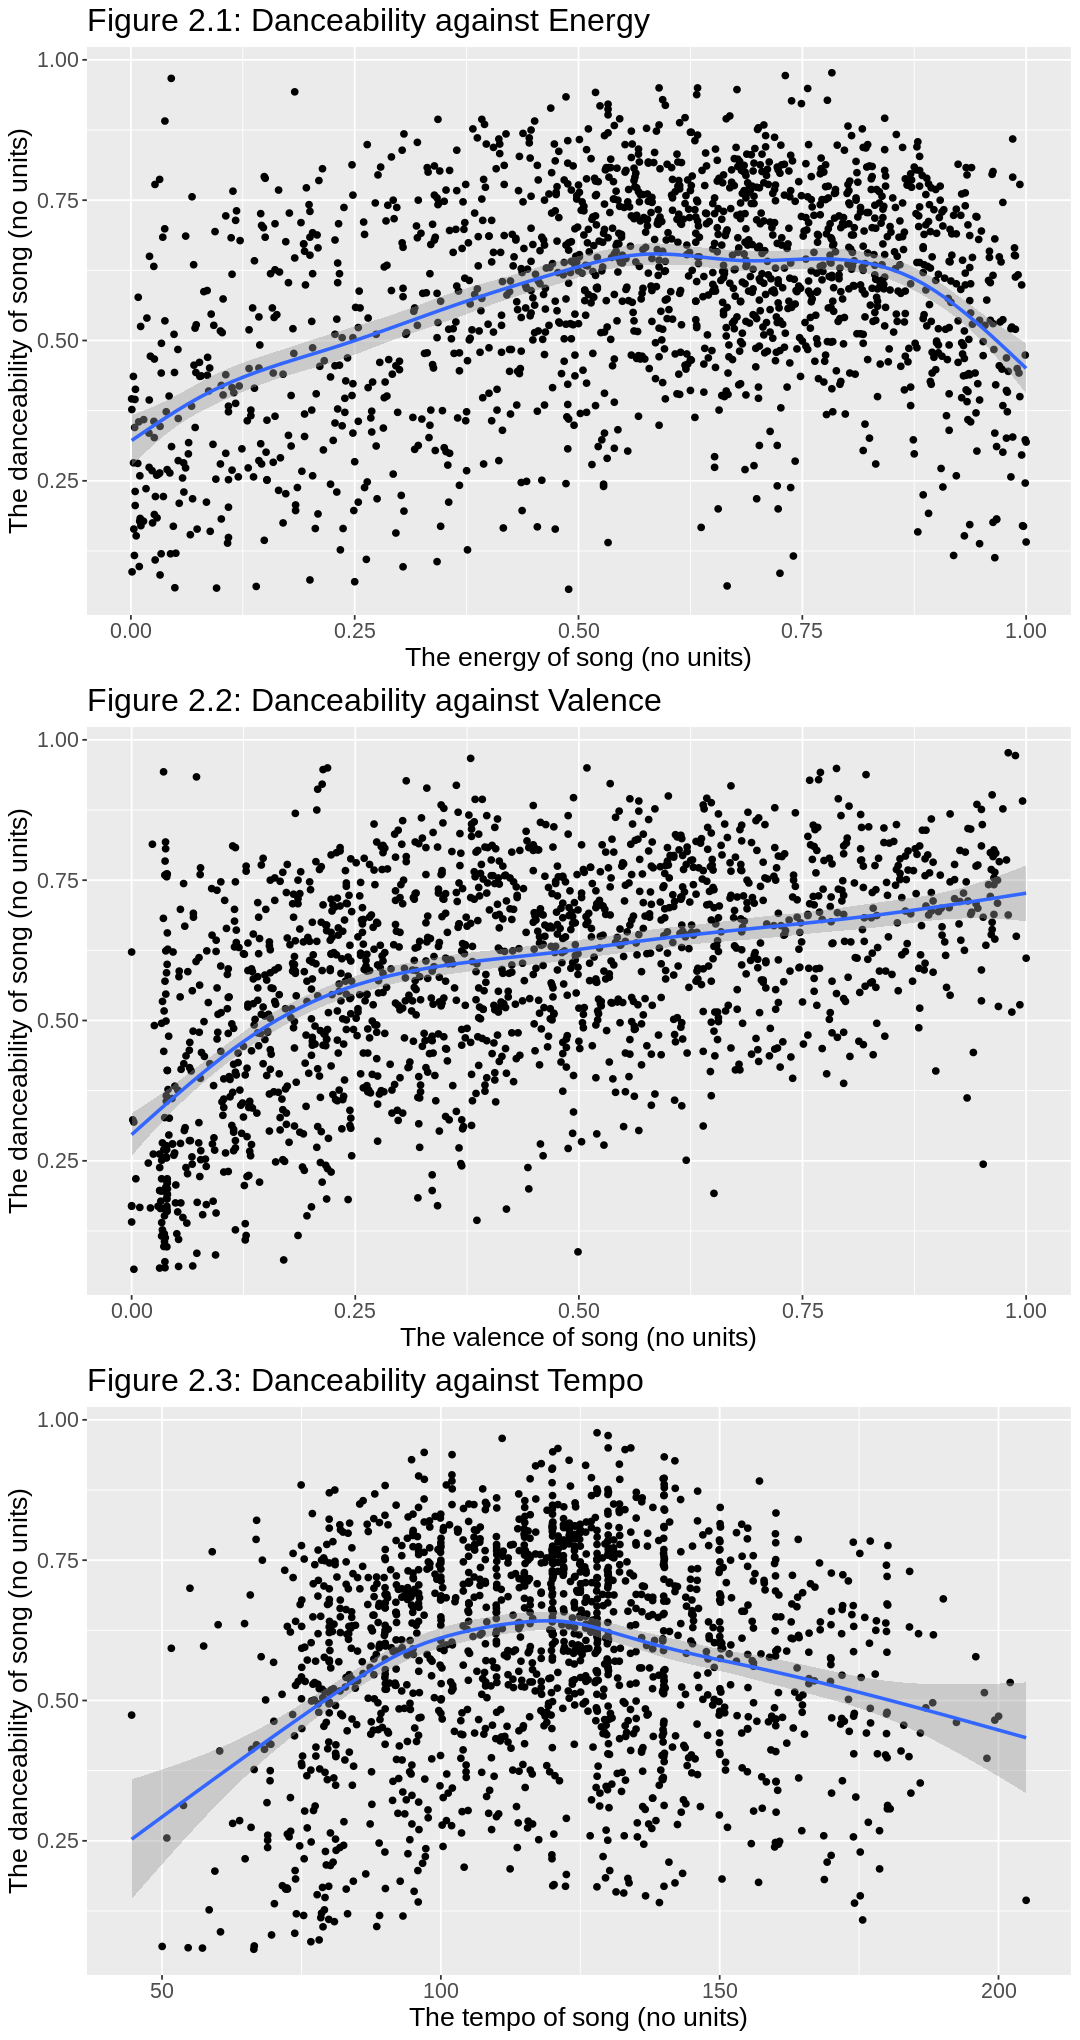

In [14]:
# ========== General Visualizations for Intuitive Model predictors ==========
options(repr.plot.width = 9, repr.plot.height = 17)
# Visualize the relationship between danceability and energy, classified by mode
intuitive_energy_plot <- ggplot(spotify_training_intuitive_unscaled, aes(x = energy, y = danceability)) +
    geom_point(alpha = 1.1) +
    geom_smooth() +
    labs(x = "The energy of song (no units)", y = "The danceability of song (no units)") +
    theme(text = element_text(size = 16)) +
    ggtitle("Figure 2.1: Danceability against Energy")

# Visualize the relationship between danceability and valence, classified by mode
intuitive_valence_plot <- ggplot(spotify_training_intuitive_unscaled, aes(x = valence, y = danceability)) +
    geom_point(alpha = 1.1) +
    geom_smooth() +
    labs(x = "The valence of song (no units)", y = "The danceability of song (no units)") +
    theme(text = element_text(size = 16)) +
    ggtitle("Figure 2.2: Danceability against Valence")

# Visualize the relationship between danceability and tempo, classified by mode
intuitive_tempo_plot <- ggplot(spotify_training_intuitive_unscaled, aes(x = tempo, y = danceability)) +
    geom_point(alpha = 1.1) +
    geom_smooth() +
    labs(x = "The tempo of song (no units)", y = "The danceability of song (no units)") +
    theme(text = element_text(size = 16)) +
    ggtitle("Figure 2.3: Danceability against Tempo")

grid.arrange(intuitive_energy_plot, intuitive_valence_plot, intuitive_tempo_plot)

Although we are working with a lot of data and hence are prone to overplotting in these visualizations, the general trend outlined by the `geom_smooth()` line is noticeable for the energy and valence of a song. For tempo, the trend is discernible, but not quite as obvious.

### <span style="color:#00bfff">Systematic Model</span>

The first stage of filtering the data needed for the regression model is to select all possible continuous and categorical variables that will be most effective for the model.
In comparison with KNN, we can include categorical variables here. However, since we might conduct cross-validation to compare this model with others in future, a categorical variable with many levels will greatly affect the performance of it. Hence, we will first remove `key` and `time_signature` from our analysis.

In [15]:
# ========== Removing large categorical variables ==========
spotify_training_systematic_filter_stage_1 <- spotify_training |>
                                               select(-key, -time_signature)
head(spotify_training_systematic_filter_stage_1, 5)

acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
8.97e-01,0.212,150857,0.254,0.8370,0.111,-20.003,0,0.0487,140.897,0.0398
9.91e-01,0.451,94000,0.143,0.9270,0.107,-25.762,1,0.0740,114.721,0.1820
3.81e-02,0.454,258949,0.860,0.0000,0.203,-4.512,1,0.3980,79.024,0.3250
1.82e-05,0.449,167226,0.973,0.0581,0.374,-3.786,1,0.0837,155.023,0.7190
4.54e-02,0.417,39070,0.733,0.0000,0.710,-10.404,1,0.2940,141.536,0.7250


Next, we will use `ggpairs()` and the correlation matrix to check the strength of the relationships between each variable and danceability. For plotting simplicity, we will first ignore `mode` as it is the only categorical variable remaining.

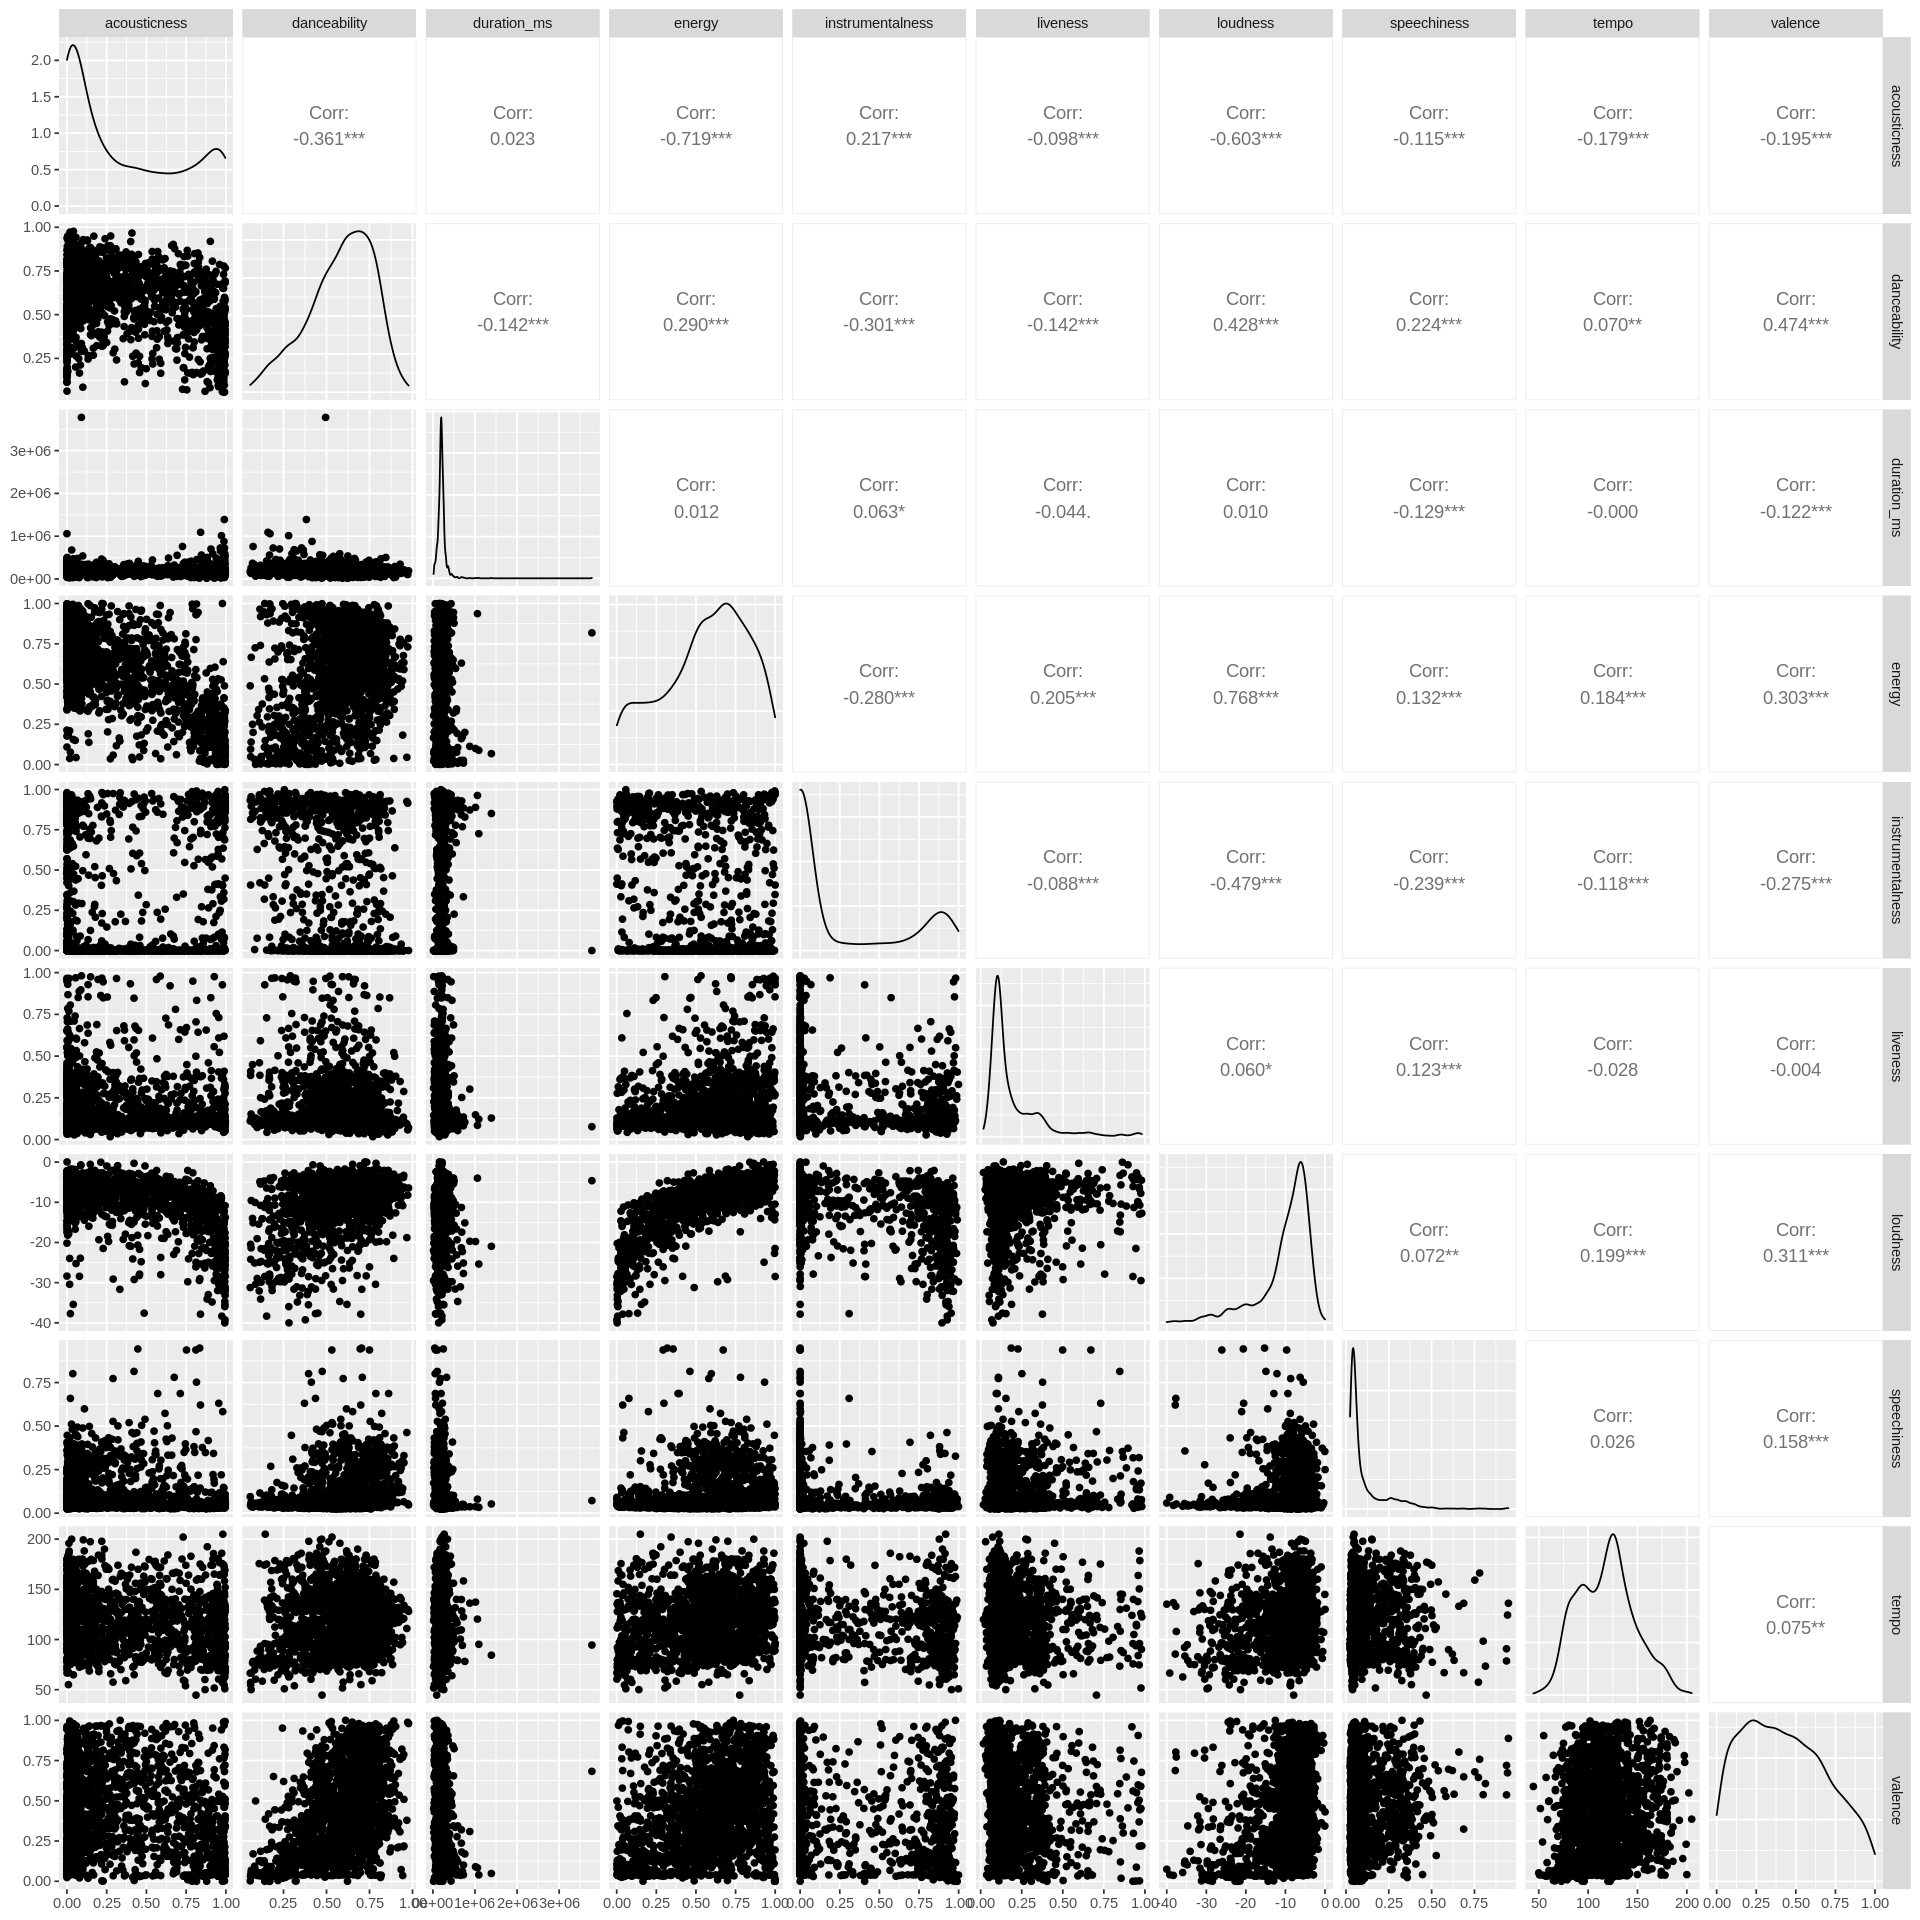

In [16]:
# ========== Create a ggpairs plot with all continuous variables ==========
options(repr.plot.width = 16, repr.plot.height = 16)
spotify_training_systematic_continuous <- spotify_training_systematic_filter_stage_1 |> select(-mode)
systematic_relationship_check_graph <- ggpairs(spotify_training_systematic_continuous)
systematic_relationship_check_matrix <- cor(spotify_training_systematic_continuous)

systematic_relationship_check_graph

In [17]:
# ========== Show the correlation matrix ==========
systematic_relationship_check_matrix

# show only variables against danceability
systematic_relationship_check_matrix[2,]

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
acousticness,1.00000000,-0.3608844,0.02276486,-0.71894285,0.21656960,-0.09836832,-0.60250639,-0.1150333,-1.791360e-01,-0.1948957
danceability,-0.36088438,1.0000000,-0.14192310,0.29012838,-0.30068773,-0.14235536,0.42785381,0.2237607,6.997526e-02,0.4744196
duration_ms,0.02276486,-0.1419231,1.00000000,0.01243531,0.06275629,-0.04415520,0.01027581,-0.1292422,-1.124598e-05,-0.1220460
energy,-0.71894285,0.2901284,0.01243531,1.00000000,-0.28032577,0.20453622,0.76759371,0.1321814,1.839844e-01,0.3033868
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
loudness,-0.6025064,0.42785381,1.027581e-02,0.7675937,-0.4785404,0.060482214,1.0000000,0.07247390,0.19894978,0.31145306
speechiness,-0.1150333,0.22376066,-1.292422e-01,0.1321814,-0.2385642,0.122818596,0.0724739,1.00000000,0.02597052,0.15754494
tempo,-0.1791360,0.06997526,-1.124598e-05,0.1839844,-0.1181706,-0.027512124,0.1989498,0.02597052,1.00000000,0.07487704
valence,-0.1948957,0.47441956,-1.220460e-01,0.3033868,-0.2753625,-0.004211908,0.3114531,0.15754494,0.07487704,1.00000000


acousticness     danceability      duration_ms           energy 
     -0.36088438       1.00000000      -0.14192310       0.29012838 
instrumentalness         liveness         loudness      speechiness 
     -0.30068773      -0.14235536       0.42785381       0.22376066 
           tempo          valence 
      0.06997526       0.47441956

Based on the plot and matrix, we note that the variables with relatively strong correlations with danceability include `valence`, `loudness`, `acousticness`, `instrumentalness`, and `energy`. We also select `mode` as one of the potential variables that can predict danceability.

In [18]:
spotify_training_systematic <- spotify_training_systematic_filter_stage_1 |>
                                    select(danceability, valence, loudness, acousticness,
                                           instrumentalness, energy, mode)

spotify_training_systematic

danceability,valence,loudness,acousticness,instrumentalness,energy,mode
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.212,0.0398,-20.003,8.97e-01,0.8370,0.254,0
0.451,0.1820,-25.762,9.91e-01,0.9270,0.143,1
0.454,0.3250,-4.512,3.81e-02,0.0000,0.860,1
0.449,0.7190,-3.786,1.82e-05,0.0581,0.973,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.788,0.887,-8.763,0.0198,2.14e-02,0.509,1
0.884,0.346,-4.886,0.0195,0.00e+00,0.590,1
0.777,0.145,-7.000,0.3470,4.16e-06,0.500,1
0.734,0.790,-2.401,0.0034,9.22e-05,0.922,1


<h2 style="color:#008a05">Data Analysis</h2>

### <span style="color:#e61a17">Intuitive Model</span>

We first begin by creating our spec, `spotify_spec`, with the `nearest_neighbor()` function, ensuring to `tune()` our neighbors and setting our mode to "regression". We also create our recipe, `spotify_recipe`, with all three predictors (`energy`, `valence`, `tempo`) against `danceability`, ensuring to scale and centre our data.

In [19]:
# ========== Creating our spec and tuning neighbours ==========
spotify_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("regression")

# ========== Creating our recipe with energy, valence, and tempo against danceability ==========
spotify_recipe <- recipe(danceability ~ ., data = spotify_training_intuitive_unscaled) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

Now, we set up our cross-validation object with 5 folds and create our `workflow`, which we pass both into `tune_grid()` to determine the optimal number for $k$, testing neighbours from 1-200. This is stored in `spotify_results`.

In [20]:
# ========== Perform cross-validation ==========
# spotify_vfold <- vfold_cv(spotify_training_intuitive_unscaled, v = 5, strata = danceability)
# spotify_workflow <- workflow() |>
#     add_recipe(spotify_recipe) |>
#     add_model(spotify_spec)
# spotify_workflow

# ========== Test 1-200 neighbours and collect results ==========
# gridvals <- tibble(neighbors = seq(1, 500))
# spotify_results <- spotify_workflow |>
#     tune_grid(resamples = spotify_vfold, grid = gridvals) |>
#     collect_metrics()
# spotify_results

Now, we filter for our $k$ value with the smallest RMSE value. We then repeat the training process into `spotify_best_fit`, using this $k$ value as our neighbours (denoted `k_min`).

In [21]:
# ========== Filter for smallest RMSE value and store k into k_min ==========
# spotify_min <- spotify_results |>
#     filter(.metric == "rmse") |>
#     arrange(mean) |>
#     slice(1)
# spotify_min 

# k_min <- spotify_min |> 
#     pull(neighbors)

# # ========== Retrain everything, using k_min neighbours and the same recipe as above ==========
# spotify_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
#     set_engine("kknn") |>
#     set_mode("regression")

# spotify_best_fit <- workflow() |>
#     add_recipe(spotify_recipe) |>
#     add_model(spotify_best_spec) |>
#     fit(data = spotify_training_intuitive_unscaled)

We can see here that `tune()` picked $k = 51$ as the ideal number of neighbours. This has an RMSPE value of around 0.15 with a standard error of around 0.003.

Now we test our model against our testing data! First, we clean up our testing data so that it contains only the required columns (`danceability`, `energy`, `valence`, `tempo`), and then use `predict()` with our workflow against our testing data.

In [22]:
# ========== Select all required columns from our testing data ==========
# spotify_testing_cleaned <- spotify_testing |>
#     select(danceability, energy, valence, tempo)

# # ========== And predict! ==========
# spotify_summary <- spotify_best_fit |>
#     predict(spotify_testing_cleaned) |>
#     bind_cols(spotify_testing_cleaned) |>
#     metrics(truth = danceability, estimate = .pred)
# spotify_summary

Our final RMSE value for our testing set is around 0.142. This means that whatever our model predicts a song's danceability (range: 0-1) to be, it can fluctuate by 0.142 up or down from the actual value.

We finally plot each predictor against the `danceability` value by using the model with our training data, with our model displayed as a blue line.

In [23]:
# ========== Predict our training data ==========
# spotify_preds <- spotify_best_fit |>
#     predict(spotify_training) |>
#     bind_cols(spotify_training)

# # ========== Plotting our data ==========
# options(repr.plot.width = 11, repr.plot.height = 20)
# spotify_plot_energy <- ggplot(spotify_preds, aes(x = energy, y = danceability)) +
#     geom_point() +
#     geom_line(mapping = aes(x = energy, y = .pred), color = "blue") +
#     labs(x = "Energy of song (no units)", y = "Dancebility of song (no units)", color = "Predicted Danceability") +
#     theme(text = element_text(size = 16)) +
#     ggtitle("Figure 3.1: Danceability against Energy of Song with Predictions")

# spotify_plot_valence <- ggplot(spotify_preds, aes(x = valence, y = danceability)) +
#     geom_point() +
#     geom_line(mapping = aes(x = valence, y = .pred), color = "blue") +
#     labs(x = "Valence of song (no units)", y = "Dancebility of song (no units)", color = "Predicted Danceability") +
#     theme(text = element_text(size = 16)) +
#     ggtitle("Figure 3.2: Danceability against Valence of Song with Predictions")

# spotify_plot_tempo <- ggplot(spotify_preds, aes(x = tempo, y = danceability)) +
#     geom_point() +
#     geom_line(mapping = aes(x = tempo, y = .pred), color = "blue") +
#     labs(x = "Tempo of song (BPM", y = "Dancebility of song (no units)", color = "Predicted Danceability") +
#     theme(text = element_text(size = 16)) +
#     ggtitle("Figure 3.3: Danceability against Tempo of Song with Predictions")

# grid.arrange(spotify_plot_energy, spotify_plot_valence, spotify_plot_tempo)

In [24]:
# !!! WRITE RESULTS HERE
# - Note potential overpredicting due to how jagged the line is

### <span style="color:#00bfff">Systematic Model</span>

We now begin our analysis using linear regression and greedy selection on all subsets.

To be specific, considering that there is no single variable that has a correlation coefficient larger than 0.5 with `danceability`, it will be quite arbitrary and invalid to use the full model or a random subset ofthe predictors directly. <br>
Thus, we would conduct greedy selection to find the best subset of variables, and the reason why we are not going to use the forward selection is that the dimension here is not so high.

We do not need to centre and scale the data as it will not affect the performance of linear regression.

In [25]:
# ========== Running subsets ==========
full_model <- regsubsets(danceability ~ ., data = spotify_training_systematic)
# show the best models under each dimension
summary(full_model)

Subset selection object
Call: regsubsets.formula(danceability ~ ., data = spotify_training_systematic)
6 Variables  (and intercept)
                 Forced in Forced out
valence              FALSE      FALSE
loudness             FALSE      FALSE
acousticness         FALSE      FALSE
instrumentalness     FALSE      FALSE
energy               FALSE      FALSE
mode1                FALSE      FALSE
1 subsets of each size up to 6
Selection Algorithm: exhaustive
         valence loudness acousticness instrumentalness energy mode1
1  ( 1 ) "*"     " "      " "          " "              " "    " "  
2  ( 1 ) "*"     "*"      " "          " "              " "    " "  
3  ( 1 ) "*"     "*"      "*"          " "              " "    " "  
4  ( 1 ) "*"     "*"      "*"          " "              "*"    " "  
5  ( 1 ) "*"     "*"      "*"          " "              "*"    "*"  
6  ( 1 ) "*"     "*"      "*"          "*"              "*"    "*"  

Now, we pick the best model under all dimensions using BIC/Mallow's Cp value.

Like cross-validation, BIC and Mallow's Cp value are also criterion that estimate the prediction error. We will be using BIC across all potential best models to pick the final best one.

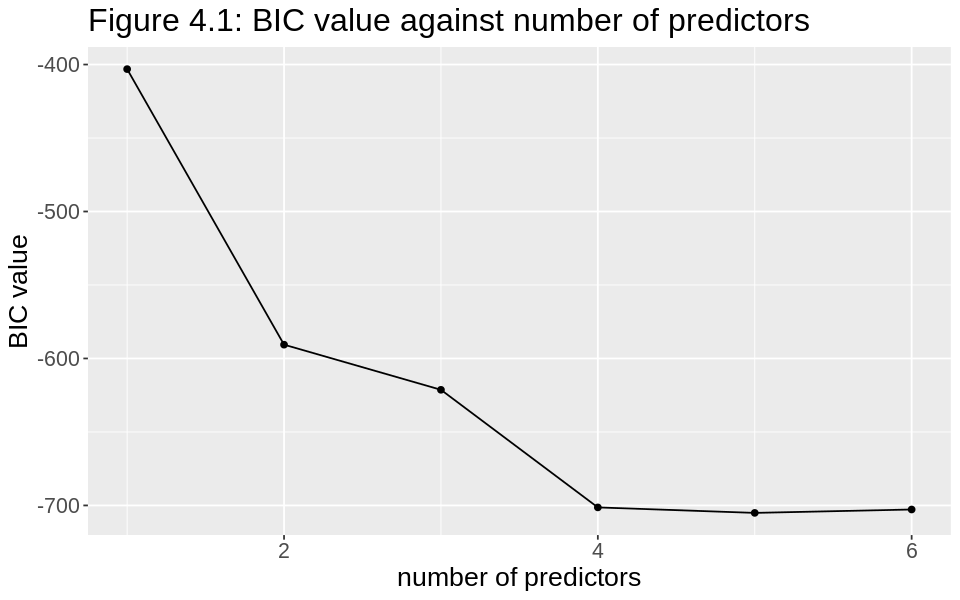

In [30]:
# ========== Create a tibble with the number of predictors and the BIC value ==========
BIC_tibble <- tibble(number_of_predictors = 1:6,
                     BIC_value = summary(full_model)$bic)

# ========== Plot the BIC value against dimension ==========
options(repr.plot.width = 8, repr.plot.height = 5)
BIC_plot <- ggplot(data = BIC_tibble,
                   aes(x = number_of_predictors,
                       y = BIC_value))+ 
            geom_point() +
            geom_line() +
            labs(x = "number of predictors", y = "BIC value") +
            theme(text = element_text(size = 16)) +
            ggtitle("Figure 4.1: BIC value against number of predictors")
BIC_plot

From this plot, we can see that the ideal BIC should be **!!!!!!! 4 !!!!!!!**. From our greedy selection summary above, we should pick **!!!!!! all but instrumentalness and mode !!!!!!!** as our predictors.

In [31]:
# ========== Selecting optimal predictors ==========
spotify_systematic_training_optimal <- spotify_training_systematic |> select(-instrumentalness, -mode)
optimal_model <- lm(danceability ~ ., data = spotify_systematic_training_optimal)

We now check the residual plot and ggplot, to test the special pattern of data and the normality of residuals.

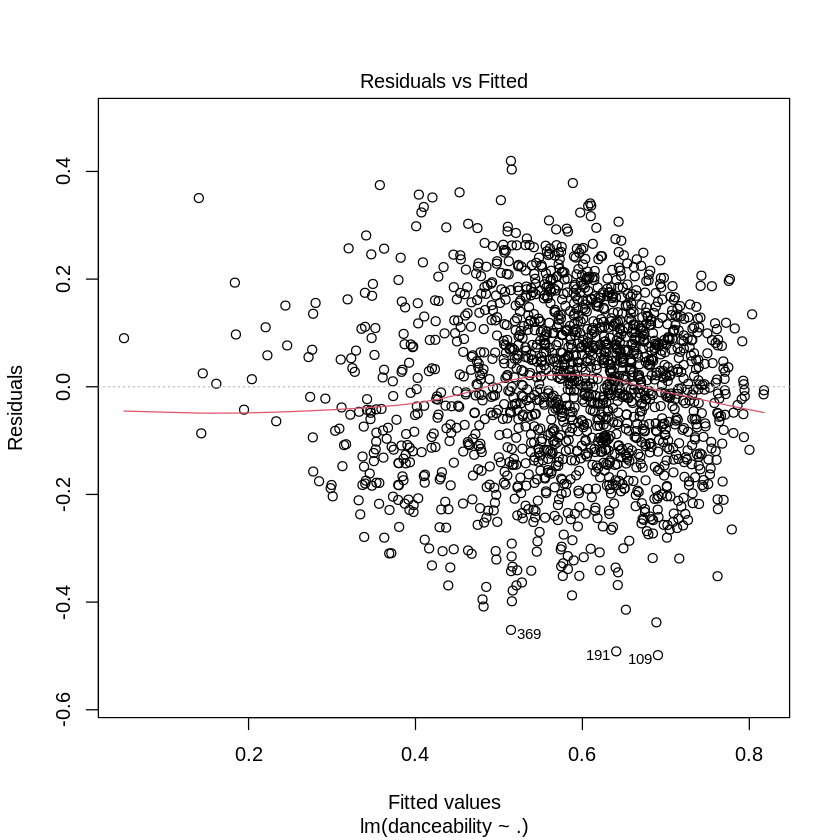

NULL

NULL

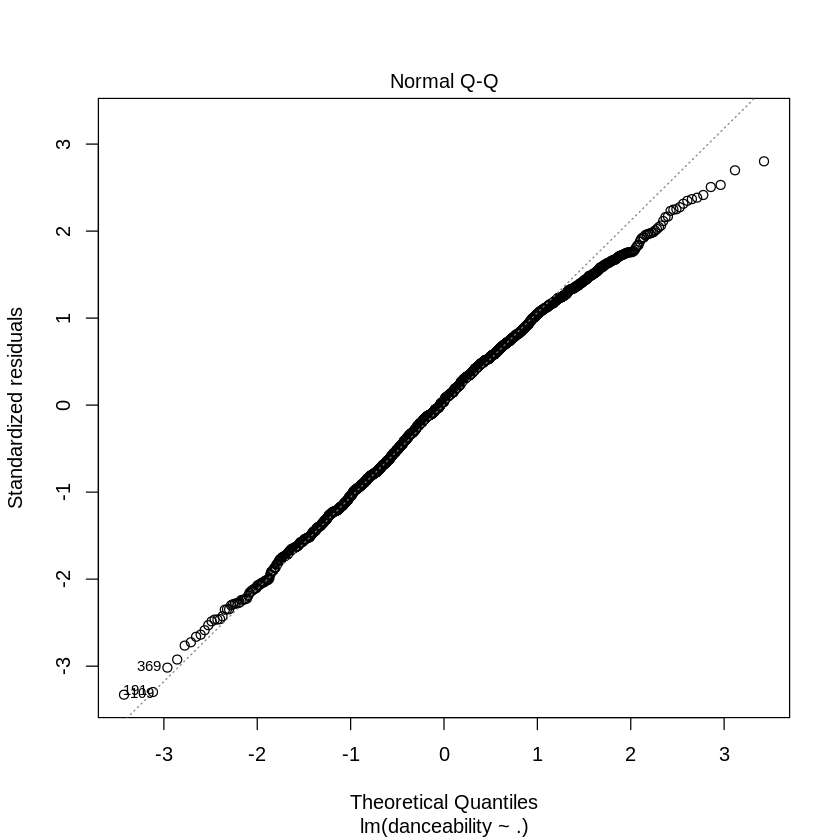

In [32]:
# ========== Check residual plot and qqplot ==========
options(repr.plot.width = 7, repr.plot.height = 7)
residual_plot <- plot(optimal_model, which = 1)
ggplot <- plot(optimal_model, which = 2)
residual_plot
ggplot

In [33]:
# since there is no apparent pattern of residuals and the qqplot is approximately a straight line
# the validity of the model is proven approximately

# then we are going to check the performance of the model on the test set
prediction_test <- predict(optimal_model, newdata = spotify_testing) |> as_tibble()
colnames(prediction_test) <- c("prediction")
# then append the prediction result to the original testing set
spotify_testing_complete <- cbind(spotify_testing, prediction_test)
# compute the rmse on the training set
RMSE_regression <- with(spotify_testing_complete, sqrt(mean((prediction-danceability)^2)))
RMSE_regression

[1] 0.1477534

<h2 style="color:#008a05">Results and Discussion</h2>

In [34]:
# ========== Forward Selection Difficulties: ==========

# However, there are some limitations of the current optimal regression model

# firstly, we didn't do any feature mapping and generation procedure, and thus it is possible that we can 
# improve our model further by adding more quadratic terms or interaction terms

# secondly, we are using BIC criterion as an estimate of prediction error, and 
# there are actually multiple choices of it, so we change the way of estimating then the result might be 
# slightly different.

# thirdly, the first stage of filtering is conducted under intuition, and so actually some of the useful information
# might have been ignored.

# also, our data may not just be linear at all LMAO which is why perhaps the forward selection model did not perform the best.
# future work could be used to look at forward selection with knn regression instead (or fancier models?)

We expect that an appropriate model will be developed to incorporate our predictor variables—valence, mode, tempo, and energy—to predict the danceability of an unknown song. The results of this study could assist musicians who desire to create danceable music according to specific characteristics. This finding could assist them in identifying and selecting danceable features of the song before creating it, thus increasing the likelihood of a successful composition.

Further, this study raises several interesting questions. For instance:
- How do other variables, like a song’s length, its key, or how wordy it is, affect its danceability?
- Is popularity based primarily on how danceable a song is?
- Since the danceability variable, per Spotify, is a combination of factors like beat strength, regularity, and stability, is it an unbiased, objective variable?
- Could the danceability of a song be viewed differently across regions, cultures, and societies?

<br><br><br>
*Thank you! - Group 79*